<p style="font-size:20px">Import libraries</p>

In [87]:
import pandas as pd
import numpy as np
import re
import string
import operator
import gc
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey
import math
%matplotlib inline

<p style="font-size:20px">Load the Map Reduced Data ~ 71,935,542 Comments</p>

In [2]:
%%time
mapped_output = []
with open ("..\part-00000", "r") as myfile:
    for line in myfile:
        line.replace('\n','')
        sub, auth, count, score = line.split(',')
        # Slicing out errant parentheses that were inadvertenty written to the reduced output
        mapped_output.append((sub[2:-1].strip(), auth[2:-1].strip(), int(count.strip()), int(score[1:-2].strip())))
myfile.close()

Wall time: 4min 22s


<p style="font-size:20px">Only consider comments with scores above or below a certain threshold</p>

In [178]:
threshold_comments = []
for i in mapped_output:
    if i[3] >= 4 or i[3] <= -4:
        threshold_comments.append(i)
        
print("Original Number of Comments:  {0}".format(len(mapped_output)))
print("Threshold Number of Comments: {0}".format(len(threshold_comments)))

Original Number of Comments:  71935542
Threshold Number of Comments: 20102190


<p style="font-size:20px">Quick check on what the data looks like</p>

In [13]:
for i in threshold_comments[241230:241240]:
    print (i)

('anime', 'metathpr4h', 1, 11)
('anime', 'metathpr4h', 1, 191)
('anime', 'metathpr4h', 1, 18)
('anime', 'metathpr4h', 1, 56)
('anime', 'metathpr4h', 1, 50)
('anime', 'metathpr4h', 1, 44)
('anime', 'metathpr4h', 1, 10)
('anime', 'metathpr4h', 1, 28)
('anime', 'metathpr4h', 1, 17)
('anime', 'metathpr4h', 1, 66)


<p style="font-size:20px">Define Reducer Function</p>
<p style="font-size:15px">Returns a tuple (subreddit, author, count) where count is number of comments by user in the subreddit</p>

In [14]:
def reducer(subAuthSorted):
    current_info = None
    current_count = 0
    current_score = 0
    info = None
    reduced_list = []
    score = None
    
    # input comes from STDIN
    for line in subAuthSorted:
        info = str(line[0]) + ' ' + str(line[1])
        count = 1
        score = line[3]

        if current_info == info:
            current_count += count
            current_score += score
        else:
            if current_info:
                reduced_list.append((current_info, current_count, current_score))
            current_info = info
            current_count = count
            current_score = score

    # Get the last tuple if needed!
    if current_info == info:
        current_count += count
        current_score += score
        reduced_list.append((current_info, current_count, current_score))
    
    tup_list = []
    for i in reduced_list:
        sub, auth = i[0].split()
        count = i[1]
        score = i[2]
    
        tup_list.append((sub, auth, count, score))
    
    return tup_list

<p style="font-size:20px">Generate Reducer Output</p>

In [179]:
%%time
reduced_threshold = reducer(threshold_comments)
print(len(reduced_threshold))
for i in reduced_threshold[2345:2355]:
    print (i)

6245692
('13reasonswhy', '0xkiss', 1, 5)
('13reasonswhy', '100000nopes', 1, 7)
('13reasonswhy', '1138bladerunner', 1, 4)
('13reasonswhy', '11591481516', 1, 4)
('13reasonswhy', '120mmsniper', 2, 11)
('13reasonswhy', '123chicken123', 1, 8)
('13reasonswhy', '123td1234', 3, 55)
('13reasonswhy', '136136', 1, 8)
('13reasonswhy', '13pt1run', 19, 341)
('13reasonswhy', '13rw96', 1, 6)
Wall time: 59.7 s


<p style="font-size:20px">Secondary Reducer: Count Number of Comments in Each Subreddit</p>

In [16]:
def subreddit_reducer(subAuthSorted, top_n=10):
    current_sub = None
    current_count = 0
    sub = None
    sub_list = []
        
    for line in subAuthSorted:
        
        sub = str(line[0])
        count = 1

        if current_sub == sub:
            current_count += count
        else:
            if current_sub:
                sub_list.append((current_sub, current_count))
            current_count = count
            current_sub = sub

    # Get the last tuple if needed
    if current_sub == sub:
        sub_list.append((current_sub, current_count))
  
    sub_list.sort(key = operator.itemgetter(1,0), reverse=True)
    
    return sub_list[:top_n]

<p style="font-size:20px">Generate Most Popular Subreddits</p>
<p style="font-size:16px">The activity in the most popular subreddits tends to be evenly distributed among most users and, due to their huge popularity, mask more interesting interactions among subreddit comments.</p>
<p style="font-size:16px">I've manually identified a list of popular subreddits to ensure they are not removed so their relationships can still be examined</p>

In [180]:
include_list = set(["politics","the_donald","rickandmorty","anime","pcmasterrace",
                    "dataisbeautiful","thewalkingdead","dbzdokkanbattle",
                    "fireemblemheroes","globaloffensivetrade","hiphopheads",
                    "relationships","europe","forhonor","conspiracy","nba","hockey",
                    "squaredcircle","soccer","nfl","mma","rupaulsdragrace","fifa",
                    "teenagers","baseball","france","ukpolitics","canada","trees","gonewild",
                    "philippines","cringeanarchy","magictcg","buildapc","television",
                    "starwars","blackpeopletwitter","india","formula1","askmen",
                    "unitedkingdom","cfb","survivor","askwomen","dnd","de","exmormon",
                    "collegebasketball","drugs","okcupid","kotakuinaction","roastme",
                    "fantasybaseball","books","random_acts_of_amazon","casualconversation",
                    "bigbrother","guns","atheism","motorcycles","argentina","australia",
                    "electronic_cigarette","loseit","mls","cricket","gaming","hearthstone",
                    "leagueoflegends","overwatch","globaloffensive","games","nintendoswitch",
                    "sports","music","personalfinance","food","movies","wow","2007scape"])

top_subs = subreddit_reducer(reduced_threshold, top_n=68)
subs_to_ignore = []
for i in top_subs:
    if i[0] not in include_list:
        subs_to_ignore.append(i[0])
        print (i[0], i[1])

print (len(subs_to_ignore))
subs_to_ignore = set(subs_to_ignore)

askreddit 282367
worldnews 79056
funny 77059
videos 75245
pics 71535
todayilearned 68954
news 68119
gifs 47239
showerthoughts 38947
aww 37899
mildlyinteresting 34637
wtf 29796
adviceanimals 27080
place 24271
oldschoolcool 21027
jokes 20536
lifeprotips 19182
iama 18933
technology 18746
nottheonion 18716
dota2 16749
explainlikeimfive 15846
me_irl 15240
interestingasfuck 15115
trashy 14458
dankmemes 13803
android 12656
tifu 12454
prequelmemes 12283
futurology 10964
30


<p style="font-size:20px">Remove comments from the most popular subreddits</p>
<p style="font-size:15px">The activity in these subreddits tends to be distributed evenly among most users<br>
and consequently masks more interesting interactions when looking at the most commented subs for a user.</p>

In [181]:
%%time
dataset = []
for tup in reduced_threshold:
    # if the comment isn't in subs_to_ignore
    # we will include it in the analysis
    if tup[0] not in subs_to_ignore:
        dataset.append(tup)
print ("Number of comments in original data: {0}\n\
Number of comments after removing popular subs: {1}".format(len(reduced_threshold), len(dataset)))

Number of comments in original data: 6245692
Number of comments after removing popular subs: 5026780
Wall time: 2.25 s


<p style="font-size:20px">Sort Output</p>
<p style="font-size:15px">By author, count, subreddit</p>

In [182]:
%%time
dataset.sort(key = operator.itemgetter(1,2,0))

Wall time: 10.6 s


<p style="font-size:20px">Structure of dataset:</p>
<p style="font-size:15px">SUBREDDIT <b>|</b> AUTHOR <b>|</b> COMMENT COUNT <b>|</b> SCORE<br>

<p style="font-size:20px">Create two data sets:
<br>Most Commented (With Positive Score) Subreddit By Author
<br>Most Commented (With Negative Score) Subreddit By Author</p>

In [183]:
%%time
# Initialize empty dicts
auth_fav_sub = {}
auth_troll_sub = {}

for tup in dataset:
    # This method relies on using a sorted list
    # of tuples, sorted by author:count:subreddit
    
    # Get author
    auth = tup[1]
    
    # Determine if the comment is for
    # a favorite sub or a troll sub
    # The check here is if the score is positive
    if tup[3] >= 0:
        if auth in auth_fav_sub:
            # if author is in the dict
            # check if comment count is
            # greater than the new one
            if auth_fav_sub[auth][1] < tup[2]:
                auth_fav_sub[auth] = (tup[0], tup[2], tup[3])
        else:
            # if the author is not in the dict
            # add his name along with the sub and count
            auth_fav_sub[auth] = (tup[0], tup[2], tup[3])
    
    # This comment must be for a troll sub
    # Check that the score is negative
    if tup[3] < 0:
        if auth in auth_troll_sub:
            # if author is in the dict
            # check if comment count is
            # greater than the new one
            if auth_troll_sub[auth][1] < tup[2]:
                auth_troll_sub[auth] = (tup[0], tup[2], tup[3])
        else:
            # if the author is not in the dict
            # add his name along with the sub and count
            auth_troll_sub[auth] = (tup[0], tup[2], tup[3])

print("Favorite Author Comments: {0}".format(len(auth_fav_sub)))
print("Favorite Troll Comments: {0}".format(len(auth_troll_sub)))

Favorite Author Comments: 1821082
Favorite Troll Comments: 149478
Wall time: 4.87 s


<p style="font-size:20px">Generate List of Authors By Their Favorite Subreddits (auth_by_fave_sub) or caves (auth_by_troll_sub)</p>
<p style="font-size:15px">These are lists of authors who have the most comments in a particular subreddit<br>
with a positive total score for those comments in the particular subreddit<br>
<b>OR</b> Trolls who have the most comments in a particular subreddit with a total negative score.</p>

In [259]:
# Set the identifying subreddit to investigate
subreddit = 'python'

In [260]:
%%time
# auth_fav_sub and auth_troll_sub are structured accordingly:
# {'author': ('subreddit', count, totalscore)}

# Find the authors based on a user-defined
# variable indicating their favorite subreddit

auth_by_fave_sub = []
for k,v in auth_fav_sub.items():
    # if the comment is for our designated subreddit
    # and the number of comments (v[1]) is above a threshold
    if str(v[0]) == subreddit and v[1] > 1:
        #print('Author: {0}\tSub: {1}\t\tCount: {2}'.format(k, v[0], v[1]))
        auth_by_fave_sub.append(k)
auth_by_fave_sub = set(auth_by_fave_sub)

##################################
### Do the same for the trolls ###
##################################

auth_by_troll_sub = []
for k,v in auth_troll_sub.items():
    # if the comment is for our designated subreddit
    # and the number of comments (v[1]) is above a threshold
    if str(v[0]) == subreddit and v[1] > 1:
        #print('Author: {0}\tSub: {1}\t\tCount: {2}'.format(k, v[0], v[1]))
        auth_by_troll_sub.append(k)
auth_by_troll_sub = set(auth_by_troll_sub)

Wall time: 1.22 s


<p style="font-size:20px">Generate Sub-Lists</p>
<p style="font-size:15px">Include only comments from authors in auth_by_fave_sub. <br>
Remove their comments associated with their favorite subreddit<br>
We're looking to identify "the rest" of their comments and associated counts</p>

In [261]:
%%time
authors_other_comments = []
authors_other_pos_comments = []
authors_other_neg_comments = []

trolls_other_comments = []
trolls_other_pos_comments = []
trolls_other_neg_comments = []

# Loop through the entire data set by each comment
for line in dataset:
    # Only consider comments made by the author whose favorite sub we are interested in
    if line[1] in auth_by_fave_sub:
        # Only consider the comment if it is for one of their "non-favorite" subs
        if line[0] != subreddit:
            authors_other_comments.append(line)
            # If the set of subreddit comments is positive
            if line[3] > 0:
                authors_other_pos_comments.append(line)
            # If the set of subreddit comments is negative
            elif line[3] < 0:
                authors_other_neg_comments.append(line)


    ##################################
    ### Do the same for the trolls ###
    ##################################
    
    # Only consider comments made by the author whose troll sub we are interested in
    if line[1] in auth_by_troll_sub:
        # Only consider the comment if it is for one of their "non-trolliest" subs
        if line[0] != subreddit:
            #print (line)
            trolls_other_comments.append(line)
            # If the set of subreddit comments is positive
            if line[3] > 0:
                trolls_other_pos_comments.append(line)
            # If the set of subreddit comments is negative
            elif line[3] < 0:
                trolls_other_neg_comments.append(line)

print("Redditors whose FAVORITE sub is {0}: {1}".format(subreddit, len(auth_by_fave_sub)))
print("They also comment in this many subs: {0}".format(len(authors_other_comments)))
print("They also comment POSITIVELY in this many subs: {0}".format(len(authors_other_pos_comments)))
print("They also comment NEGATIVELY in this many subs: {0}".format(len(authors_other_neg_comments)))
print("------------------------------------------------------")
print("Redditors whose TROLLIEST sub is {0}: {1}".format(subreddit, len(auth_by_troll_sub)))
print("They also comment in this many subs: {0}".format(len(trolls_other_comments)))
print("They also comment POSITIVELY in this many subs: {0}".format(len(trolls_other_pos_comments)))
print("They also comment NEGATIVELY in this many subs: {0}".format(len(trolls_other_neg_comments)))

Redditors whose FAVORITE sub is python: 96
They also comment in this many subs: 161
They also comment POSITIVELY in this many subs: 155
They also comment NEGATIVELY in this many subs: 6
------------------------------------------------------
Redditors whose TROLLIEST sub is python: 6
They also comment in this many subs: 25
They also comment POSITIVELY in this many subs: 24
They also comment NEGATIVELY in this many subs: 1
Wall time: 1.73 s


<p style="font-size:20px">Generate Text Output</p>

In [262]:
pos_subcounts = {}
neg_subcounts = {}
for i in authors_other_pos_comments:
    sub = i[0]
    count = i[2]
    sub_score = int(i[3])
    
    if sub_score > 0:
        if sub in pos_subcounts:
            pos_subcounts[sub][0] += count
            pos_subcounts[sub][1] += sub_score
        else:
            pos_subcounts[sub] = [count, sub_score]

print ("----------------------------------------------------------------------------")
print ("People who are upvoted often in {0}, get positive responses in these subs:".format(subreddit))
print ("----------------------------------------------------------------------------")

top_pos_others = []
for k,v in pos_subcounts.items():
    # v[0] is the number of comments in a specific subreddit
    # we want to ensure this meets a minimum threshold
    if v[0] >= 2:
        # Calculate the average score for the subreddit
        # and append it to the list
        top_pos_others.append((k, v[0], v[1]/v[0]))
top_pos_others.sort(key = operator.itemgetter(1),reverse=True)

for i in top_pos_others[:15]:
    print ("Sub: {0}\tNumber of Comments: {1}\tAvg Score: {2}".format(i[0], i[1], i[2]))


----------------------------------------------------------------------------
People who are upvoted often in python, get positive responses in these subs:
----------------------------------------------------------------------------
Sub: programming	Number of Comments: 17	Avg Score: 27.470588235294116
Sub: linux	Number of Comments: 13	Avg Score: 10.0
Sub: learnpython	Number of Comments: 11	Avg Score: 9.545454545454545
Sub: politics	Number of Comments: 10	Avg Score: 16.0
Sub: ubuntu	Number of Comments: 5	Avg Score: 22.4
Sub: weather	Number of Comments: 5	Avg Score: 7.0
Sub: surfing	Number of Comments: 5	Avg Score: 12.2
Sub: devops	Number of Comments: 4	Avg Score: 2.75
Sub: java	Number of Comments: 4	Avg Score: 6.75
Sub: sharks	Number of Comments: 3	Avg Score: 29.666666666666668
Sub: vim	Number of Comments: 3	Avg Score: 7.333333333333333
Sub: webdev	Number of Comments: 3	Avg Score: 8.666666666666666
Sub: datascience	Number of Comments: 3	Avg Score: 6.0
Sub: europe	Number of Comments: 3	Av

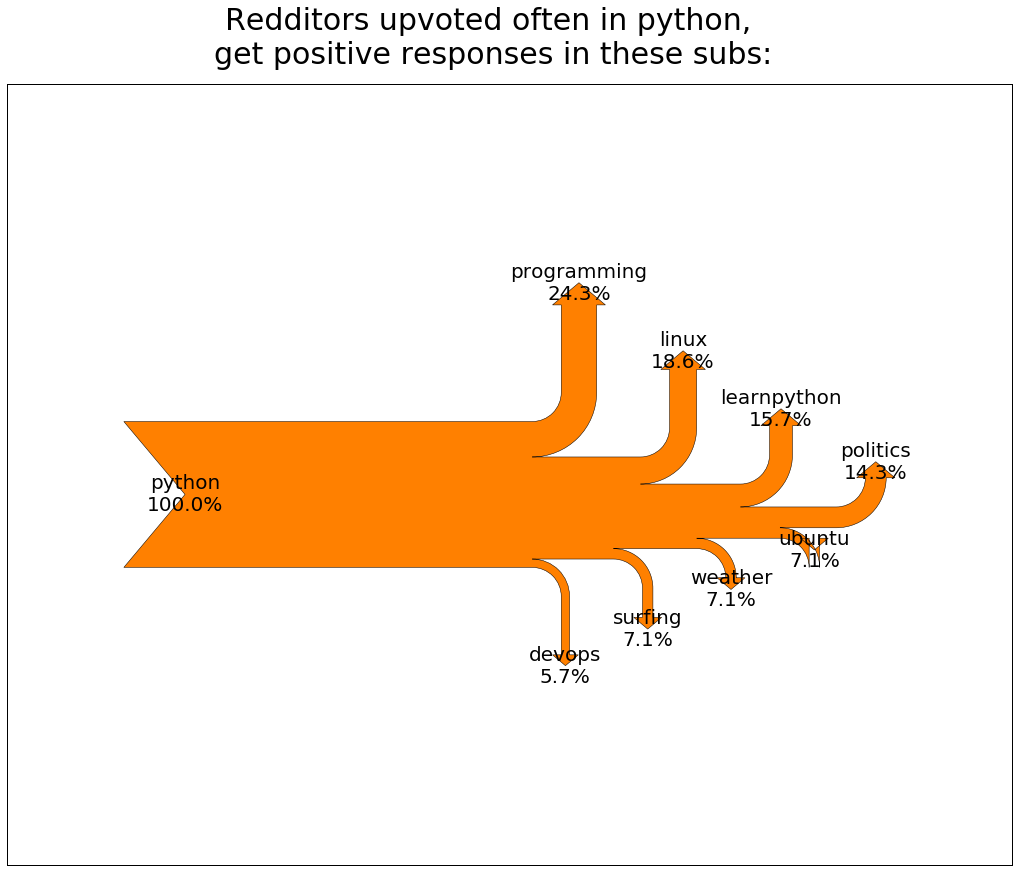

In [263]:
fig = plt.figure(figsize=(18, 14))
plt.figtext(.5,.92,
            "Redditors upvoted often in {0}, \nget positive responses in these subs:".format(subreddit),
            fontsize=30, ha='center')
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])

colors = ["#FF0000", "#FF4000", "#FF8000", "#FFBF00", "#FFFF00"]

first_flows = [100]
first_labels = [subreddit]
first_orientations = [0]#,1,1,1,-1,-1
first_pathlength = [0.25]
n=8
tot = 0
for i in top_pos_others[0:n]:
    tot += i[1]
for i in top_pos_others[0:n]:
    first_flows.append(-100*(i[1]/tot))
for i in top_pos_others[0:n]:
    first_labels.append(i[0])

# find midpoint for paths
midpoint = math.ceil(n/2)
top_path_length = .4
for i in top_pos_others[0:n]:
    if midpoint > 0:
        first_pathlength.append(top_path_length)
        top_path_length -= 0.1
        midpoint -= 1
    else:
        first_pathlength.append(top_path_length)
        top_path_length += 0.1

midpoint = math.ceil(n/2)
for i in top_pos_others[0:n]:
    if midpoint > 0:
        first_orientations.append(1)
        midpoint -= 1
    else:
        first_orientations.append(-1)

sankey = Sankey(ax=ax, scale=0.005, offset=0., format='%.01f', unit='%')
sankey.add(flows = first_flows,
           labels = first_labels,
           orientations = first_orientations,
           pathlengths = first_pathlength,
           trunklength = 1.5,
           facecolor = colors[2])

diagrams = sankey.finish()
for text in diagrams[0].texts:
    text.set_fontsize('20')